# Multitask Learning Example

from https://github.com/Hui-Li/multi-task-learning-example-PyTorch/blob/master/multi-task-learning-example-PyTorch.ipynb

title: Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics
arxiv: https://arxiv.org/pdf/1705.07115.pdf

In [ ]:
import math

import pylab
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
def gen_data(N):
    X = np.random.randn(N, 1)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, 1)
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, 1)
    return X, Y1, Y2


class TrainData(Dataset):

    def __init__(self, feature_num, X, Y1, Y2):

        self.feature_num = feature_num

        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y1 = torch.tensor(Y1, dtype=torch.float32)
        self.Y2 = torch.tensor(Y2, dtype=torch.float32)

    def __len__(self):
        return self.feature_num

    def __getitem__(self, idx):
        return self.X[idx,:], self.Y1[idx,:], self.Y2[idx,:]

In [ ]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num, model):
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, input, targets):

        outputs = self.model(input)

        precision1 = torch.exp(-self.log_vars[0])
        loss = torch.sum(precision1 * (targets[0] - outputs[0]) ** 2. + self.log_vars[0], -1)

        precision2 = torch.exp(-self.log_vars[1])
        loss += torch.sum(precision2 * (targets[1] - outputs[1]) ** 2. + self.log_vars[1], -1)

        loss = torch.mean(loss)
        
        print(f"precision1: {precision1}")
        print(f"precision2: {precision2}")

        return loss, self.log_vars.data.tolist()


class MTLModel(torch.nn.Module):
    def __init__(self, n_hidden, n_output):
        super(MTLModel, self).__init__()

        self.net1 = nn.Sequential(nn.Linear(1, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_output))
        self.net2 = nn.Sequential(nn.Linear(1, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_output))

    def forward(self, x):
        return [self.net1(x), self.net2(x)]

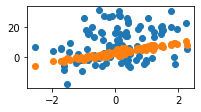

In [ ]:
%matplotlib inline
np.random.seed(0)

feature_num = 100
nb_epoch = 100
batch_size = 20
hidden_dim = 1024

X, Y1, Y2 = gen_data(feature_num)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])


In [ ]:
train_data = TrainData(feature_num, X, Y1, Y2)
train_data_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

model = MTLModel(hidden_dim, 1)

mtl = MultiTaskLossWrapper(2, model)
mtl

# https://github.com/keras-team/keras/blob/master/keras/optimizers.py
# k.epsilon() = keras.backend.epsilon()
optimizer = torch.optim.Adam(mtl.parameters(), lr=0.001, eps=1e-07)

loss_list = []
for t in range(nb_epoch):
    cumulative_loss = 0
    
    for X, Y1, Y2 in train_data_loader:

        loss, log_vars = mtl(X, [Y1, Y2])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumulative_loss += loss.item()

    loss_list.append(cumulative_loss/batch_size)

precision1: 1.0
precision2: 1.0
precision1: 0.9990004897117615
precision2: 0.9990004897117615
precision1: 0.9980084896087646
precision2: 0.9980095624923706
precision1: 0.997039258480072
precision2: 0.9970176219940186
precision1: 0.9960571527481079
precision2: 0.9960400462150574
precision1: 0.9950671195983887
precision2: 0.9950805902481079
precision1: 0.9940718412399292
precision2: 0.9941424131393433
precision1: 0.9930749535560608
precision2: 0.9932420253753662
precision1: 0.9921287298202515
precision2: 0.9923914074897766
precision1: 0.991202175617218
precision2: 0.9915634989738464
precision1: 0.9902649521827698
precision2: 0.9907726645469666
precision1: 0.98931884765625
precision2: 0.990025520324707
precision1: 0.9883562922477722
precision2: 0.9893231391906738
precision1: 0.9874255061149597
precision2: 0.9886627793312073
precision1: 0.9865036606788635
precision2: 0.98805832862854
precision1: 0.985619843006134
precision2: 0.9875041842460632
precision1: 0.9847414493560791
precision2: 0.9

precision1: 0.8851442933082581
precision2: 0.9833611249923706
precision1: 0.8844395279884338
precision2: 0.9833981990814209
precision1: 0.8837080597877502
precision2: 0.9834343791007996
precision1: 0.8829765915870667
precision2: 0.9834690690040588
precision1: 0.8822411298751831
precision2: 0.983507513999939
precision1: 0.8815180659294128
precision2: 0.9835580587387085
precision1: 0.8807879686355591
precision2: 0.9836093187332153
precision1: 0.880073606967926
precision2: 0.9836482405662537
precision1: 0.8793362379074097
precision2: 0.9836751222610474
precision1: 0.8786056637763977
precision2: 0.9837127923965454
precision1: 0.8778829574584961
precision2: 0.9837526679039001
precision1: 0.8771747946739197
precision2: 0.9838045835494995
precision1: 0.8764663934707642
precision2: 0.9838457107543945
precision1: 0.8757494688034058
precision2: 0.9838976860046387
precision1: 0.8750190734863281
precision2: 0.9839337468147278
precision1: 0.8742901682853699
precision2: 0.983969509601593
precision1:

precision1: 0.7829639911651611
precision2: 0.9909343123435974
precision1: 0.7823233008384705
precision2: 0.9910069704055786
precision1: 0.781687319278717
precision2: 0.9910894632339478
precision1: 0.7810598611831665
precision2: 0.9911645650863647
precision1: 0.7804303765296936
precision2: 0.9912243485450745
precision1: 0.7798037528991699
precision2: 0.9912834167480469
precision1: 0.7791709303855896
precision2: 0.9913327693939209
precision1: 0.7785284519195557
precision2: 0.9913761019706726
precision1: 0.7778874039649963
precision2: 0.9914178252220154
precision1: 0.777264416217804
precision2: 0.9914847612380981
precision1: 0.7766100168228149
precision2: 0.9915511608123779
precision1: 0.7759723663330078
precision2: 0.991595447063446
precision1: 0.7753431797027588
precision2: 0.9916426539421082
precision1: 0.7747346758842468
precision2: 0.991701066493988
precision1: 0.774118185043335
precision2: 0.9917724132537842
precision1: 0.7735124230384827
precision2: 0.9918582439422607
precision1: 0

precision1: 0.6991401314735413
precision2: 1.0010231733322144
precision1: 0.6986037492752075
precision2: 1.0010995864868164
precision1: 0.6980698108673096
precision2: 1.001198649406433
precision1: 0.6975240111351013
precision2: 1.0012983083724976
precision1: 0.6969711184501648
precision2: 1.0013936758041382
precision1: 0.696437418460846
precision2: 1.0014736652374268
precision1: 0.6959038972854614
precision2: 1.0015472173690796
precision1: 0.6953637599945068
precision2: 1.001603126525879
precision1: 0.6948279142379761
precision2: 1.0016616582870483
precision1: 0.6942878365516663
precision2: 1.0017337799072266
precision1: 0.6937370300292969
precision2: 1.0018123388290405
precision1: 0.6932076811790466
precision2: 1.0018917322158813
precision1: 0.6926832795143127
precision2: 1.0019667148590088
precision1: 0.6921514868736267
precision2: 1.0020581483840942
precision1: 0.6916290521621704
precision2: 1.0021735429763794
precision1: 0.6910802721977234
precision2: 1.002263069152832
precision1: 